In [3]:
%matplotlib inline

import numpy as np
import pandas as pd
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
import matplotlib.pyplot as plt
from bisect import bisect_left
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.dates as mdates

In [18]:
es = Elasticsearch(hosts=[{'host':'atlas-kibana-dev.mwt2.org', 'port':9200}],timeout=120)

In [255]:
my_query = {
    '_source':['delay_median', 'destSite', 'dest', 'src', 'timestamp'],
    'query':{
        'bool':{
            'must':[
                {'term': {'_type':'latency'}},
                {'term': {'srcSite': 'CERN-PROD'}},
                {'range': {'timestamp': {'gte': "1492387200000", 'lte': "1502755200000"}}},
            ],
        }     
    }
}
index = "network_weather-*"
scroll = list(scan(client=es, index=index, query=my_query))

In [256]:
types = []
timestamps = []
delay_median = []
dest = []
count = 0

for data in scroll:
    delay_median.append(data['_source']['delay_median'])
    if 'destSite' not in data["_source"].keys():
        dest.append(np.nan)
    else:
        dest.append(data['_source']['destSite'])    
    timestamps.append(data['_source']['timestamp'])

data_router = pd.DataFrame({'delay_median': delay_median, 'destSite': dest, 'timestamp': timestamps})
print(data_router.head())
print(len(data_router))

   delay_median     destSite      timestamp
0         20.50          NaN  1496537912000
1          9.74  FMPhI-UNIBA  1501372817000
2         53.70         MWT2  1496537576000
3         20.70          NaN  1496536928000
4         13.56      DESY-ZN  1499561161000
14810669


In [258]:
data_router = data_router.dropna()

In [259]:
my_query2 = {
    '_source':['destSite', 'packet_loss', 'timestamp'],
    'query':{
        'bool':{
            'must':[
                {'term':{'_type':'packet_loss_rate'}},
                {'term': {'srcSite': 'CERN-PROD'}},
                {'range': {'timestamp': {'gte': "1492387200000", 'lte': "1502755200000"}}},
            ],
        }     
    }
}
index = "network_weather-*"
scroll2 = list(scan(client=es, index=index, query=my_query2))

In [260]:
types = []
timestamps = []
packet_loss = []
dest = []

for data in scroll2:
    if 'destSite' not in data["_source"].keys():
        dest.append(np.nan)
    else:
        dest.append(data['_source']['destSite']) 
    timestamps.append(data['_source']['timestamp'])
    if 'packet_loss' not in data["_source"].keys():
        packet_loss.append(np.nan)
    else:
        packet_loss.append(data['_source']['packet_loss'])
        

data_router2 = pd.DataFrame({'packet_loss': packet_loss, 'destSite': dest, 'timestamp': timestamps})
print(data_router2.head())

       destSite  packet_loss      timestamp
0           NaN          0.0  1502238569000
1           NaN          0.0  1502237417000
2           NaN          0.0  1502238509000
3           NaN          0.0  1502238138000
4  TECHNION-HEP          0.0  1499474767000


In [261]:
data_router2 = data_router2.dropna()
print(len(data_router2))

11606578


In [262]:
data_input = data_router.merge(data_router2, on=['destSite', 'timestamp'])
print(len(data_input))
data_input.to_pickle('data_routers/packet_loss_delay_raw.pkl')

12606100


In [263]:
my_query3 = {
    '_source':['dstInterface', 'utilization', 'timestamp'],
    'query':{
        'bool':{
            'must':[
                {'term': {'srcInterface': 'CERN'}},
                {'term': {'_type': 'netflow_lhcopn'}},
                {'range': {'timestamp': {'gte': "1492387200000", 'lte': "1502755200000"}}},
            ],
        }     
    }
}
index = "network_weather-*"
scroll3 = list(scan(client=es, index=index, query=my_query3))

In [264]:
types = []
timestamps = []
throughput = []
dest = []


for data in scroll3:
    if 'dstInterface' not in data["_source"].keys():
        dest.append(np.nan)
    else:
        dest.append(data['_source']['dstInterface']) 
    timestamps.append(data['_source']['timestamp'])
    if 'utilization' not in data["_source"].keys():
        throughput.append(np.nan)
    else:
        throughput.append(data['_source']['utilization'])
        

data_router3 = pd.DataFrame({'throughput': throughput, 'destSite': dest, 'timestamp': timestamps})
data_router3.sort_values('throughput', inplace=True)
data_router3.drop_duplicates(inplace=True)

In [265]:
sites = []
timestamps = []
throughputs = []
for index, row in data_router3.iterrows():
    dest = row['destSite'].split(' ')
    if dest[0] not in sites:
        sites.append(dest[0])
        timestamps.append(row['timestamp'])
        throughputs.append(row['throughput'])
    elif timestamps[sites.index(dest[0])] == row['timestamp']:
        throughputs[sites.index(dest[0])] += row['throughput']
    else:
        sites.append(dest[0])
        timestamps.append(row['timestamp'])
        throughputs.append(row['throughput'])

data_throughput = pd.DataFrame({'throughput': throughputs, 'destSite': sites, 'timestamp': timestamps})
print(data_throughput.head())

    destSite  throughput      timestamp
0  UK-T1-RAL  2856859458  1498651800000
1      NL-T1           0  1493163900000
2      NL-T1           0  1501814700000
3    JINR-T1  3834232535  1497914400000
4  RRC-KI-T1  1355006403  1497914700000


In [267]:
data_throughput.to_pickle('/data_routers/utilization_raw.pkl')

In [2]:
data_throughput = pd.read_pickle('data_routers/utilization_raw.pkl')

In [3]:
print(len(data_throughput))

1049206


In [36]:
site_mapping ={
    'FR-CCIN2P3': 'IN2P3-CC',
    'IT-INFN-CNAF': 'INFN-T1',
    'US-T1_BNL': 'BNL-ATLAS',
    'RRC-KI-T1': 'RRC-KI',
    'ES-PIC': 'pic',
    'DE-KIT': 'FZK-LCG2',
    'NL-T1': 'SARA-MATRIX',
    'UK-T1-RAL': 'RAL-LCG2',
    'NDGF': 'NDGF-T1',
    'CA-TRIUMF': 'TRIUMF-LCG2',
}

def static_site_mapping(data_throughput_map, site_mapping):
    for index, row in data_throughput_map.iterrows():
        if index % 10000 == 0:
            print(index)
        if row['destSite'] in site_mapping.keys():
            data_throughput_map.loc[index, 'destSite'] = site_mapping[row['destSite']]
        elif row['destSite'] == 'DE-KIT:':
            data_throughput_map.loc[index, 'destSite'] = 'FZK-LCG2'
        else:
            data_throughput_map.drop(data_throughput_map.index[index])
    return data_throughput_map


In [5]:
data_throughput = static_site_mapping(data_throughput, site_mapping)

0


KeyboardInterrupt: 

In [25]:
data_throughput.to_pickle('data_routers/utilization_raw.pkl')

In [37]:
site_set = {'FNAL': 100, 'BNL': 100, 'INFN': 40, 'RAL': 30, 'NDGF': 20}

In [66]:
def findIndexClosestToTimestamp_mod(timestamp, dataPoints, collumThatIsNotNAN, dest):
    '''
    Returns a data point from dataPoints, that is closest to the given timestamp.
    As well the dataPoint will not be nan in the collum "collumThatIsNotNAN"
    Complexity of this command: O( log( len(dataPoints) ) )
    '''
    
    timestamps_toSearch = dataPoints.axes[0]
    cols = list(dataPoints.axes[1])
    data = dataPoints.values
    # bisect only works because we know our list is sorted
    pos = bisect_left(timestamps_toSearch, timestamp)
    if pos == len(dataPoints):
        pos = len(dataPoints)-1
    #print(pos)
    # find the closest datapoint, that is not a NAN and return it
    return pos

def makeNewDataSet_NN(data_from_routers, data_from_perfSonar, num_of_last_measurements=10, cut_throughput=0.7, throughput_max=(20*1e9), dest=""):
    # bisect doesn't work if the data is not sorted this way...
    data_from_routers = data_from_routers.sort_index(ascending=True).copy(deep=True)
    data_from_perfSonar = data_from_perfSonar.sort_index(ascending=True).copy(deep=True)
    data = []
    delay_all_time_std = data_from_perfSonar['delay_median'].std()
    loss_all_time_avg = data_from_perfSonar['packet_loss'].mean()
    loss_all_time_std = data_from_perfSonar['packet_loss'].std()
    for i in range(len(data_from_routers)):
        if i%10000 == 0:
            print(i)
        currentTimestamp = data_from_routers['timestamp'].values[i]
        if currentTimestamp > 1000000000000:
            currentTimestamp = currentTimestamp/1000
        index_perfSonar = findIndexClosestToTimestamp_mod(currentTimestamp, data_from_perfSonar, 'delay_median', dest)
        zw = dict(data_from_perfSonar.iloc[index_perfSonar])
        # include all time data
        zw['delay_all_time_std'] = delay_all_time_std
        zw['loss_all_time_avg'] = loss_all_time_avg
        zw['loss_all_time_std'] = loss_all_time_std
        # add last measurements
        if index_perfSonar < num_of_last_measurements:
            continue
        sumdelay = 0
        sumdelay_square = 0
        sumloss = 0
        sumloss_square = 0
        for j in range(1, num_of_last_measurements+1):
            dataPoint = data_from_perfSonar.iloc[index_perfSonar-j]
            zw['delay_avg_past_'+str(j)] = dataPoint['delay_median']
            sumdelay += dataPoint['delay_median']
            sumdelay_square += dataPoint['delay_median']*dataPoint['delay_median']
            zw['packet_loss_past_'+str(j)] = dataPoint['packet_loss']
            sumloss += dataPoint['packet_loss']
            sumloss_square += dataPoint['packet_loss']*dataPoint['packet_loss']
        zw['delay_avg_past_avg'] = sumdelay/num_of_last_measurements
        zw['packet_loss_past_avg'] = sumloss/num_of_last_measurements
        zw['delay_avg_past_std'] = np.sqrt((sumdelay_square/num_of_last_measurements)-(sumdelay/num_of_last_measurements)**2)
        zw['packet_loss_past_std'] = np.sqrt((sumloss_square/num_of_last_measurements)-(sumloss/num_of_last_measurements)**2)
        if math.isnan(zw['packet_loss_past_std']):
            zw['packet_loss_past_std'] = 0
        if math.isnan(zw['delay_avg_past_std']):
            zw['delay_avg_past_std'] = 0
        # add timestamp and throughput
        zw['timestamp'] = currentTimestamp
        zw['throughput'] = data_from_routers['throughput'].values[i]
        if zw['throughput'] <= cut_throughput*throughput_max:
            zw['throughput'] = 0
        data.append(zw)
        
    data = pd.DataFrame.from_dict(data)
    return data

def normalizeDataSet(dataSet, scaler_feature_range=(0, 1), scaler=None):
    # make sure we don't change our original object (wo don't want that)
    # use the sktlearn.preprocessing procedures, they prommis to be quite flexible
    workDataSet = dataSet.copy(deep=True)
    # append zeroes so that we are actually normalized to zero
    #zeroesDataFrame = pd.DataFrame(np.zeros([1,len(workDataSet.axes[1])]), columns=workDataSet.axes[1])
    #workDataSet = workDataSet.append(zeroesDataFrame, ignore_index=True)
    # fill up our nans as the function dosen't run with nans 
    workDataSet = workDataSet.fillna(0)
    collums = []
    for collum in workDataSet.axes[1]:
        # what to skip:
        if collum == "timestamp" or collum == "throughput":
            continue
        collums.append(collum)
    # if you want to keep the scaler, then split this into a fit and a transform call
    if scaler == None:
        scaler = preprocessing.MinMaxScaler(feature_range=scaler_feature_range).fit(workDataSet[collums].as_matrix())
    workDataSet[collums] = scaler.transform(workDataSet[collums].as_matrix())
    # remove zeroes again
    #workDataSet = workDataSet.drop(len(workDataSet)-1, axis=0)
    return workDataSet, scaler

def inverseNormalizeDataSet(dataSet, scaler):
    # make sure we don't change our original object (wo don't want that)
    # use the sktlearn.preprocessing procedures, they prommis to be quite flexible
    workDataSet = dataSet.copy(deep=True)
    collums = []
    for collum in workDataSet.axes[1]:
        # what to skip:
        if collum == "timestamp" or collum == "throughput":
            continue
        collums.append(collum)
    workDataSet[collums] = scaler.inverse_transform(workDataSet[collums].as_matrix())
    # remove zeroes again
    #workDataSet = workDataSet.drop(len(workDataSet)-1, axis=0)
    return workDataSet

def normalize_throughput(throughput_array, throughputMaxGBits):
    zw = throughput_array
    zw = throughput_array/(throughputMaxGBits*1e9)
    zw = (zw*0.8)+0.1
    return zw

def inverses_normalize_throughput(throughput_array, throughputMaxGBits):
    zw = throughput_array
    zw = (zw-0.1)/0.8
    zw = zw * (throughputMaxGBits*1e9)
    return zw

def make_all_data_sets_for_NN(num_of_last_measurements, cut_throughput, throughput_mapping):
    # get all directions
    data_set = pd.DataFrame()
    for dest in set(data_throughput['destSite']):
        print(dest)
        # skip JINR-T1 it has super strange router data...
        # as well skip RAL, they have a bad router
        if "JINR" in dest  or "RRC" in dest or "KISTI" in dest:
            continue
        throughputMaxGBits = 10
        for key in throughput_mapping.keys():
            if "dest" in key:
                throughputMaxGBits = throughput_mapping[key]
        # make dataset for direction: in
        if dest not in list(data_input['destSite']):
            continue
        if dest == 'NDGF-T1':
            continue
        data = data_throughput[dest == data_throughput['destSite']]
        data_from_routers = data[['throughput','timestamp']]
        data_from_perfSonar = data_input[dest == data_input['destSite']].copy(deep=True)
        data_set_tmp = makeNewDataSet_NN(data_from_routers, data_from_perfSonar,
                                         num_of_last_measurements=num_of_last_measurements,
                                         cut_throughput=cut_throughput, throughput_max=(throughputMaxGBits*1e9), dest=dest)
        # normalize throughput
        if len(data_set_tmp.keys()) == 0:
            continue
        data_set_tmp['throughput'] = normalize_throughput(data_set_tmp['throughput'], throughputMaxGBits)
        # append data_set
        data_set = data_set.append(data_set_tmp, ignore_index=True)
        data_set = data_set.drop(['destSite'], axis=1)
    return data_set

In [74]:
data_input = pd.read_pickle('data_routers/packet_loss_delay_raw.pkl')
#data_throughput = pd.read_pickle('data_routers/utilization_raw.pkl')
#data_throughput = data_throughput[data_throughput['destSite'] == 'pic']
#data_input = data_input[data_input['destSite'] == 'pic']

In [75]:
print(data_input["packet_loss"].std())
print(data_input["packet_loss"].mean())
print('mode', data_input["packet_loss"].mode())

0.012861980937990881
0.0005263228218390641
mode 0    0.0
dtype: float64


In [67]:
data_set_pic = make_all_data_sets_for_NN(num_of_last_measurements = 15, cut_throughput=0.7, throughput_mapping=site_set)

pic
0
10000
20000
30000


In [50]:
data_set = make_all_data_sets_for_NN(num_of_last_measurements = 15, cut_throughput=0.7, throughput_mapping=site_set)
print(len(data_set))

US-FNAL-CMS
KR-KISTI
RRC-KI
SARA-MATRIX
0
10000
20000
30000
40000
50000
60000
INFN-T1
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
pic
0
10000
20000
30000
NDGF-T1
RAL-LCG2
0
10000
20000
30000
40000
50000
60000
70000
FZK-LCG2
0
10000
20000
30000
40000
50000
60000
TW-ASGC
US-T1-BNL
IN2P3-CC
0
10000
20000
30000
40000
50000
60000
JINR-T1
TRIUMF-LCG2
0
10000
20000
30000
478567


In [41]:
data_set = data_set[data_set['delay_median'] >= 0]
print(min(data_set['delay_median']))
data_set.to_pickle('data_set.pkl')

5.3


In [54]:
data_set = pd.read_pickle('data_set.pkl')

In [55]:
print(max(data_set['timestamp']), min(data_set['timestamp']))

1502755200.0 1492611900.0


In [56]:
data_set = pd.read_pickle('data_set.pkl')
print(len(data_set))
hendrik_data_set = pd.read_pickle('hendrik_data_set.pkl')
print(len(hendrik_data_set))
frames = [data_set, hendrik_data_set]
data_set = pd.concat(frames)
print(len(data_set))

411428
25633
437061


In [73]:
print(data_set_pic["packet_loss"].std())
print(data_set_pic["packet_loss"].mean())
print('mode', data_set_pic["packet_loss"].mode())

0.0
0.0
mode 0    0.0
dtype: float64


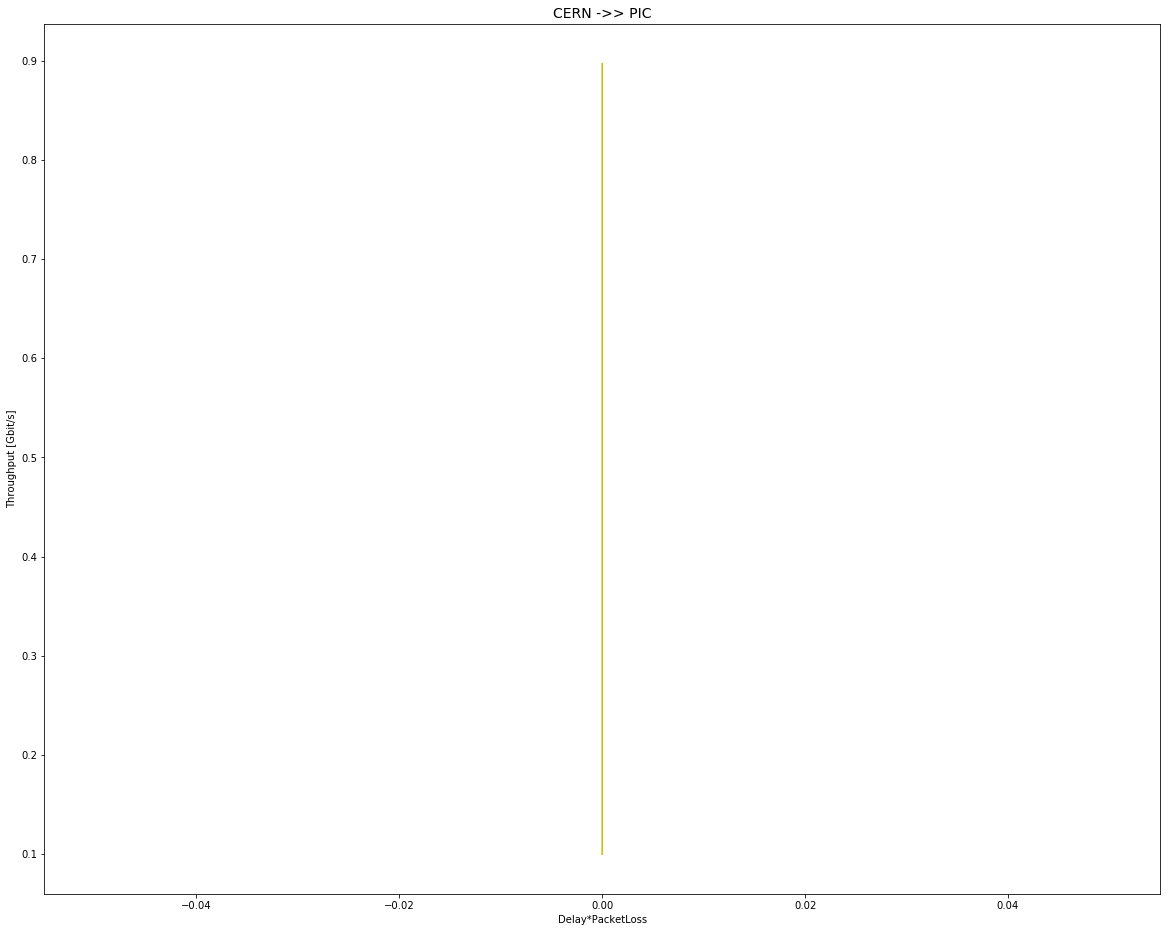

In [70]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20,16)
fig.set_dpi(1000)
# plt.title(title,fontsize=14)
#
# make first axis
# ax1.hlines(inverses_normalize_throughput((minimum+cut_offset), throughputMaxGBits)/1e9, [0], [999999999999999999], label="cut_off")
plt.title("CERN ->> PIC",fontsize=14)
ax1.plot(data_set_pic["delay_median"]*data_set_pic["packet_loss"], data_set_pic['throughput'], 'y')
# get throughput
# legends and lables
ax1.set_ylabel("Throughput [Gbit/s]")
ax1.set_xlabel("Delay*PacketLoss")
# saving?
plt.show()

In [57]:
print(max(data_set['timestamp']), min(data_set['timestamp']))

1502755200.0 1473609600.0


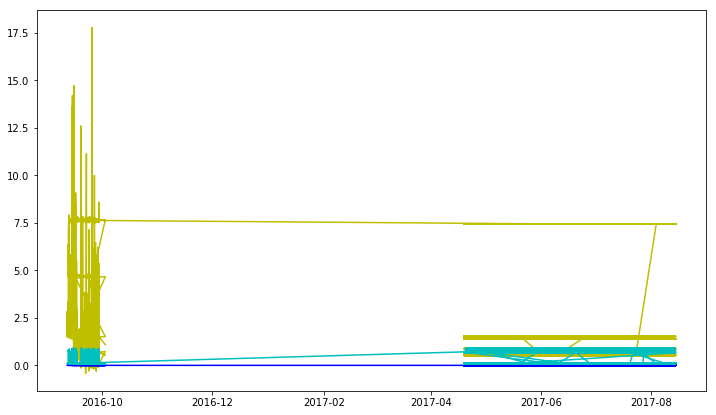

In [58]:
dates_data_set = []
for stamp in data_set['timestamp']:     
    dates_data_set.append(datetime.datetime.fromtimestamp(stamp))
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
fig.set_dpi(1000)

ax.plot(dates_data_set, data_set["delay_median"]/10, 'y', label=r'Delay /10')
# get throughput
ax.plot(dates_data_set, data_set["packet_loss"]/10, 'b', label=r'Packet loss')

ax.plot(dates_data_set, (data_set['throughput']), 'c', label=r'Throughput (actual from routers)')
plt.show()

In [59]:
print(data_set["delay_median"].std())
print(data_set["delay_median"].mean())
print('mode', data_set["delay_median"].mode())

19.378163545048867
14.847903748029879
mode 0    5.3
dtype: float64


In [60]:
data_set_normalized, scaler_for_dataSet_all = normalizeDataSet(data_set)
data_set_normalized_NN_Input = data_set_normalized.drop(['throughput','timestamp'], axis=1)
data_set_normalized_NN_Output = data_set_normalized['throughput']
print("INPUT", data_set_normalized_NN_Input.columns)

INPUT Index(['delay_all_time_avg', 'delay_all_time_min', 'delay_all_time_std',
       'delay_avg', 'delay_avg_gradient', 'delay_avg_past_1',
       'delay_avg_past_10', 'delay_avg_past_11', 'delay_avg_past_12',
       'delay_avg_past_13', 'delay_avg_past_14', 'delay_avg_past_15',
       'delay_avg_past_2', 'delay_avg_past_3', 'delay_avg_past_4',
       'delay_avg_past_5', 'delay_avg_past_6', 'delay_avg_past_7',
       'delay_avg_past_8', 'delay_avg_past_9', 'delay_avg_past_avg',
       'delay_avg_past_std', 'delay_median', 'delay_std', 'loss_all_time_avg',
       'loss_all_time_std', 'packet_loss', 'packet_loss_gradient',
       'packet_loss_past_1', 'packet_loss_past_10', 'packet_loss_past_11',
       'packet_loss_past_12', 'packet_loss_past_13', 'packet_loss_past_14',
       'packet_loss_past_15', 'packet_loss_past_2', 'packet_loss_past_3',
       'packet_loss_past_4', 'packet_loss_past_5', 'packet_loss_past_6',
       'packet_loss_past_7', 'packet_loss_past_8', 'packet_loss_past_9',

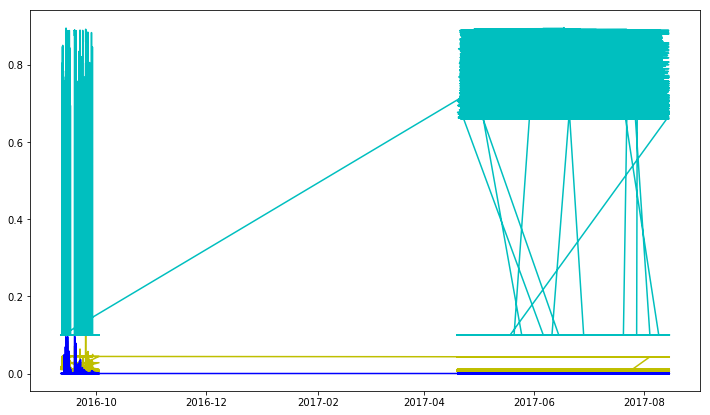

In [62]:
dates_data_set = []
for stamp in data_set_normalized['timestamp']:
    dates_data_set.append(datetime.datetime.fromtimestamp(stamp))
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
fig.set_dpi(1000)

ax.plot(dates_data_set, data_set_normalized["delay_median"]/10, 'y', label=r'Delay /10')
# get throughput
ax.plot(dates_data_set, data_set_normalized["packet_loss"]/10, 'b', label=r'Packet loss')

ax.plot(dates_data_set, (data_set_normalized['throughput']), 'c', label=r'Throughput (actual from routers)')
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(data_set_normalized_NN_Input, data_set_normalized_NN_Output, test_size=0.25, random_state=0)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras 

#earlyStopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=50, verbose=0, mode='auto')
activation_func = 'relu'
layer_init = ""
# standard:
b_size = 512
validation_split = 0.00
training_epochs = 5000
dropout_ratio = 0.5
model = Sequential()
model.add(Dense(100, input_dim=len(X_train.axes[1]), activation=activation_func, init='uniform'))
model.add(Dropout(dropout_ratio))
model.add(Dense(50, activation=activation_func))
model.add(Dropout(dropout_ratio))
model.add(Dense(5, activation=activation_func))
# last/output layer
model.add(Dense(1, activation=activation_func))

model.compile(optimizer='rmsprop', loss='mse')
history = model.fit(X_train.as_matrix(), y_train.as_matrix(),
                    nb_epoch=training_epochs, batch_size=b_size, shuffle=True, validation_split=validation_split) # ,
                  # callbacks = [earlyStopping])

/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(100, kernel_initializer="uniform", input_dim=46, activation="relu")`
/home/ivukotic/anaconda3/lib/python3.5/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/5000
327795/327795 [==============================] - 1s - loss: 0.0129     
Epoch 2/5000
327795/327795 [==============================] - 1s - loss: 0.0125     
Epoch 3/5000
327795/327795 [==============================] - 1s - loss: 0.0124     
Epoch 4/5000
327795/327795 [==============================] - 1s - loss: 0.0124     
Epoch 5/5000
327795/327795 [==============================] - 1s - loss: 0.0124     
Epoch 6/5000
327795/327795 [==============================] - 1s - loss: 0.0124     
Epoch 7/5000
327795/327795 [==============================] - 1s - loss: 0.0124     
Epoch 8/5000
327795/327795 [==============================] - 1s - loss: 0.0124     
Epoch 9/5000
327795/327795 [==============================] - 1s - loss: 0.0124     
Epoch 10/5000
327795/327795 [==============================] - 1s - loss: 0.0124     
Epoch 11/5000
327795/327795 [==============================] - 1s - loss: 0.0124     
Epoch 12/5000
327795/327795 [==============================] - 

In [ ]:
import pickle
# save model
model.save('global_NN.h5')  # creates a HDF5 file 'global_NN_model_1.h5'
# save our scaler
pickle.dump(scaler_for_dataSet_all, open( "global_NN_scaler.pkl", "wb" ),
            protocol=2 )

In [3]:
from keras.models import load_model

b_size = 512
training_epochs = 5000


model = load_model('global_NN.h5')


In [ ]:
score = model.evaluate(X_test.as_matrix(), y_test.as_matrix(),
                       batch_size=b_size)
prediction = model.predict(X_test.as_matrix(), batch_size=b_size)

In [197]:
print(len(y_test.as_matrix()))

143385


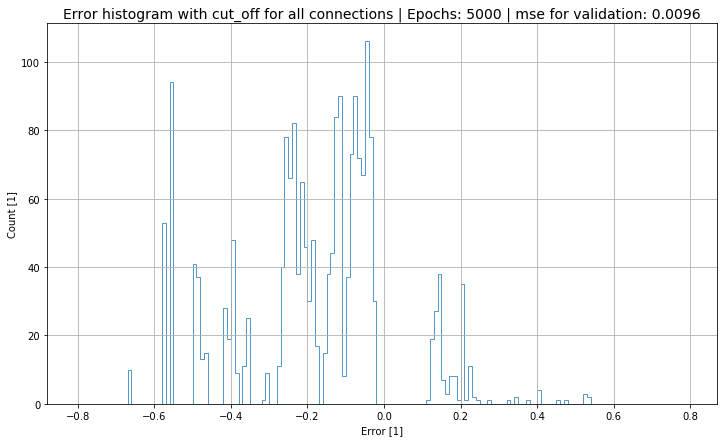

In [31]:
# make error histogram
bins = np.arange(-0.8, 0.8, 0.01)
#bins = 300
cut_offset = 0.1
#cut_offset = 0.06
savePath = ''
title = "Error histogram with cut_off for all connections"
title +=" | Epochs: "+ str(training_epochs) 
title += " | "+ str(model.loss) +" for validation: " + str(round(score, 4))

rs_prediction = np.reshape(prediction, (len(prediction),))
diff = rs_prediction - y_test.as_matrix()
# cut median, its falsely called minimum here
minimum = np.median(rs_prediction)
validPoints = []
for i in range(len(diff)):
    if rs_prediction[i] >= (minimum+cut_offset):
        validPoints.append(diff[i])
fig, ax1 = plt.subplots()
fig.set_size_inches(12,7)
fig.set_dpi(300)
n, bins, patches = plt.hist(validPoints, bins, normed=False, histtype='step', facecolor='green',
                            alpha=0.75, orientation='vertical')

plt.xlabel("Error [1]")
plt.ylabel('Count [1]')
plt.title(title, fontsize=14)
plt.grid(True)

if savePath != '' :
    fname = title
    plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

In [151]:
my_query = {
    '_source':['delay_median', 'destSite', 'dest', 'src', 'timestamp'],
    'query':{
        'bool':{
            'must':[
                {'term': {'_type':'latency'}},
                {'term': {'srcSite': 'CERN-PROD'}},
                {'range': {'timestamp': {'gte': "1503360000000", 'lte': "1503477381000"}}},
            ],
        }     
    }
}
index = "network_weather-*"
scroll = list(scan(client=es, index=index, query=my_query))

In [152]:
types = []
timestamps = []
delay_median = []
dest = []
count = 0

for data in scroll:
    delay_median.append(data['_source']['delay_median'])
    if 'destSite' not in data["_source"].keys():
        dest.append(np.nan)
    else:
        dest.append(data['_source']['destSite'])    
    timestamps.append(data['_source']['timestamp'])

data_router = pd.DataFrame({'delay_median': delay_median, 'destSite': dest, 'timestamp': timestamps})
print(data_router.head())
print(len(data_router))

   delay_median           destSite      timestamp
0          8.21       UKI-LT2-QMUL  1503383632000
1          8.65       UKI-LT2-RHUL  1503473343000
2        162.22    Australia-ATLAS  1503474888000
3        242.48    Australia-ATLAS  1503475129000
4         13.99  INFN-NAPOLI-ATLAS  1503470139000
145911


In [153]:
data_router = data_router.dropna()

In [154]:
my_query2 = {
    '_source':['destSite', 'packet_loss', 'timestamp'],
    'query':{
        'bool':{
            'must':[
                {'term':{'_type':'packet_loss_rate'}},
                {'term': {'srcSite': 'CERN-PROD'}},
                {'range': {'timestamp': {'gte': "1503360000000", 'lte': "1503477381000"}}},
            ],
        }     
    }
}
index = "network_weather-*"
scroll2 = list(scan(client=es, index=index, query=my_query2))

In [155]:
types = []
timestamps = []
packet_loss = []
dest = []

for data in scroll2:
    if 'destSite' not in data["_source"].keys():
        dest.append(np.nan)
    else:
        dest.append(data['_source']['destSite']) 
    timestamps.append(data['_source']['timestamp'])
    if 'packet_loss' not in data["_source"].keys():
        packet_loss.append(np.nan)
    else:
        packet_loss.append(data['_source']['packet_loss'])
        

data_router2 = pd.DataFrame({'packet_loss': packet_loss, 'destSite': dest, 'timestamp': timestamps})
print(data_router2.head())

          destSite  packet_loss      timestamp
0              NaN          0.0  1503461532000
1  Australia-ATLAS          0.0  1503477292000
2  Australia-ATLAS          0.0  1503477112000
3          JINR-T1          0.0  1503448723000
4          JINR-T1          0.0  1503448844000


In [156]:
data_router2 = data_router2.dropna()
print(len(data_router2))

122568


In [157]:
data_input = data_router.merge(data_router2, on=['destSite', 'timestamp'])
print(len(data_input))

124347


In [158]:
my_query3 = {
    '_source':['dstInterface', 'utilization', 'timestamp'],
    'query':{
        'bool':{
            'must':[
                {'term': {'srcInterface': 'CERN'}},
                {'term': {'_type': 'netflow_lhcopn'}},
                {'range': {'timestamp': {'gte': "1503360000000", 'lte': "1503477381000"}}},
            ],
        }     
    }
}
index = "network_weather-*"
scroll3 = list(scan(client=es, index=index, query=my_query3))

In [159]:
types = []
timestamps = []
throughput = []
dest = []


for data in scroll3:
    if 'dstInterface' not in data["_source"].keys():
        dest.append(np.nan)
    else:
        dest.append(data['_source']['dstInterface']) 
    timestamps.append(data['_source']['timestamp'])
    if 'utilization' not in data["_source"].keys():
        throughput.append(np.nan)
    else:
        throughput.append(data['_source']['utilization'])
        

data_router3 = pd.DataFrame({'throughput': throughput, 'destSite': dest, 'timestamp': timestamps})
data_router3.sort_values('throughput', inplace=True)
data_router3.drop_duplicates(inplace=True)

In [160]:
sites = []
timestamps = []
throughputs = []
for index, row in data_router3.iterrows():
    dest = row['destSite'].split(' ')
    if dest[0] not in sites:
        sites.append(dest[0])
        timestamps.append(row['timestamp'])
        throughputs.append(row['throughput'])
    elif timestamps[sites.index(dest[0])] == row['timestamp']:
        throughputs[sites.index(dest[0])] += row['throughput']
    else:
        sites.append(dest[0])
        timestamps.append(row['timestamp'])
        throughputs.append(row['throughput'])

data_throughput = pd.DataFrame({'throughput': throughputs, 'destSite': sites, 'timestamp': timestamps})
print(data_throughput.head())

  destSite  throughput      timestamp
0  TW-ASGC   588627935  1503450600000
1  TW-ASGC         136  1503419700000
2  TW-ASGC         137  1503430800000
3  TW-ASGC         139  1503440400000
4  TW-ASGC         139  1503371400000


In [161]:
data_input_CC = data_input[data_input['destSite'] == 'IN2P3-CC']
data_input_RAL = data_input[data_input['destSite'] == 'RAL-LCG2']

In [162]:
print(set(data_input['destSite']))
print(set(data_throughput['destSite']))

{'AGLT2', 'UFlorida-HPC', 'CA-SCINET-T2', 'SFU-LCG2', 'RRC-KI-T1', 'Australia-ATLAS', 'INFN-T1', 'BNL-ATLAS', 'RO-02-NIPNE', 'UKI-NORTHGRID-MAN-HEP', 'CSCS-LCG2', 'CA-MCGILL-CLUMEQ-T2', 'IN2P3-CPPM', 'DESY-ZN', 'Taiwan-LCG2', 'MWT2', 'Vanderbilt', 'DESY-HH', 'NDGF-T1', 'JINR-T1', 'JINR-LCG2', 'UKI-SCOTGRID-GLASGOW', 'TR-03-METU', 'FMPhI-UNIBA', 'GRIF', 'pic', 'IN2P3-CC', 'TRIUMF-LCG2', 'TECHNION-HEP', 'UKI-LT2-RHUL', 'praguelcg2', 'UAM-LCG2', 'UKI-LT2-QMUL', 'GLOW', 'RU-Protvino-IHEP', 'UKI-SOUTHGRID-RALPP', 'TOKYO-LCG2', 'INFN-NAPOLI-ATLAS', 'RAL-LCG2', 'BEIJING-LCG2', 'UKI-NORTHGRID-LANCS-HEP', 'BUDAPEST', 'RO-07-NIPNE'}
{'KR-KISTI', 'NDGF', 'US-T1-BNL', 'NL-T1', 'RRC-KI-T1', 'US-FNAL-CMS', 'ES-PIC', 'TW-ASGC', 'DE-KIT:', 'DE-KIT', 'IT-INFN-CNAF', 'JINR-T1', 'UK-T1-RAL', 'CA-TRIUMF', 'FR-CCIN2P3'}


In [163]:
data_throughput_CC = data_throughput[data_throughput['destSite'] == 'FR-CCIN2P3']
print(range(0, len(data_throughput_CC)))
data_throughput_CC.reindex(range(0, len(data_throughput_CC)))
print(data_throughput_CC.head())
data_throughput_RAL = data_throughput[data_throughput['destSite'] == 'UK-T1-RAL']
data_throughput_RAL.reindex(range(0, len(data_throughput_RAL)))
print(data_throughput_RAL.head())

range(0, 781)
        destSite  throughput      timestamp
3825  FR-CCIN2P3  1758425914  1503474300000
3904  FR-CCIN2P3    69965113  1503438300000
4042  FR-CCIN2P3    98526257  1503366300000
4118  FR-CCIN2P3   110501685  1503462300000
4140  FR-CCIN2P3   115578557  1503457200000
       destSite  throughput      timestamp
3647  UK-T1-RAL   274844559  1503392700000
3697  UK-T1-RAL    36896125  1503386400000
3809  UK-T1-RAL    50114203  1503392400000
3869  UK-T1-RAL    59002307  1503390600000
3900  UK-T1-RAL    68764517  1503392400000


In [164]:
print(len(data_input_CC['destSite']))
print(len(data_input_RAL['destSite']))
print(len(data_throughput_CC['destSite']))
print(len(data_throughput_RAL['destSite']))

3880
3885
781
1171


In [165]:
data_throughput = static_site_mapping(data_throughput_map=data_throughput_CC, site_mapping=site_mapping)
data_input = data_input_CC
data_set_validation = make_all_data_sets_for_NN(num_of_last_measurements = 15, cut_throughput=0.7, throughput_mapping=site_set)
print(len(data_set_validation))

/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


IN2P3-CC
IN2P3-CC 0
781


In [222]:
print(data_set_validation.head())

   delay_all_time_std  delay_avg_past_1  delay_avg_past_10  delay_avg_past_11  \
0            3.578341             13.62              13.58              12.74   
1            3.578341              7.52               7.99              13.58   
2            3.578341              7.60               8.01               7.99   
3            3.578341              7.60               8.01               7.99   
4            3.578341              7.60               8.01               7.99   

   delay_avg_past_12  delay_avg_past_13  delay_avg_past_14  delay_avg_past_15  \
0               7.96              12.80              12.79               7.98   
1              12.74               7.96              12.80              12.79   
2              13.58              12.74               7.96              12.80   
3              13.58              12.74               7.96              12.80   
4              13.58              12.74               7.96              12.80   

   delay_avg_past_2  delay

In [84]:
data_set_normalized, scaler_for_dataSet = normalizeDataSet(data_set_validation)
data_set_normalized_NN_Input = data_set_normalized.drop(['throughput','timestamp'], axis=1)
data_set_normalized_NN_Output = data_set_normalized['throughput']
print("INPUT", data_set_normalized_NN_Input.columns)

INPUT Index(['delay_all_time_std', 'delay_avg_past_1', 'delay_avg_past_10',
       'delay_avg_past_11', 'delay_avg_past_12', 'delay_avg_past_13',
       'delay_avg_past_14', 'delay_avg_past_15', 'delay_avg_past_2',
       'delay_avg_past_3', 'delay_avg_past_4', 'delay_avg_past_5',
       'delay_avg_past_6', 'delay_avg_past_7', 'delay_avg_past_8',
       'delay_avg_past_9', 'delay_avg_past_avg', 'delay_avg_past_std',
       'delay_median', 'loss_all_time_avg', 'loss_all_time_std', 'packet_loss',
       'packet_loss_past_1', 'packet_loss_past_10', 'packet_loss_past_11',
       'packet_loss_past_12', 'packet_loss_past_13', 'packet_loss_past_14',
       'packet_loss_past_15', 'packet_loss_past_2', 'packet_loss_past_3',
       'packet_loss_past_4', 'packet_loss_past_5', 'packet_loss_past_6',
       'packet_loss_past_7', 'packet_loss_past_8', 'packet_loss_past_9',
       'packet_loss_past_avg', 'packet_loss_past_std'],
      dtype='object')


In [85]:
score = model.evaluate(data_set_normalized_NN_Input.as_matrix(), data_set_normalized_NN_Output.as_matrix(),
                       batch_size=b_size)
prediction = model.predict(data_set_normalized_NN_Input.as_matrix(), batch_size=b_size)

 512/1171 [============>.................] - ETA: 0s

In [166]:
data_set_normalized_NN_Input = data_set_validation.drop(['throughput','timestamp'], axis=1)
data_set_normalized_NN_Output = data_set_validation['throughput']

score = model.evaluate(data_set_normalized_NN_Input.as_matrix(), data_set_normalized_NN_Output.as_matrix(),
                       batch_size=b_size)
prediction = model.predict(data_set_normalized_NN_Input.as_matrix(), batch_size=b_size)

512/781 [==================>...........] - ETA: 0s

In [285]:
print(max(data_set_normalized_NN_Output))
print((prediction))

0.79883921592
[[ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]
 [ 0.]

In [225]:
def makePlot_forNN(src, dest, timeframe, data_set_local, prediction_bw, title_suffix='', savePath=''):
    # set stuff up
    title = "NN plot for "
    # make dates
    dates_data_set = []
    for stamp in data_set_local['timestamp']:
        dates_data_set.append(datetime.datetime.fromtimestamp(stamp))
    # plot the data we got
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18,12)
    fig.set_dpi(300)
    plt.title(title,fontsize=14)
    
    # make first axis
    ax1.hlines(inverses_normalize_throughput((minimum+cut_offset), throughputMaxGBits)/1e9, [0], [999999999999999999], label="cut_off")
    ax1.plot(dates_data_set, data_set_local["delay_median"]/10, 'y', label=r'Delay /10')
    # get throughput
    ax1.plot(dates_data_set, data_set_local['throughput'], 'c', label=r'Throughput (actual from routers)')
    ax1.plot(dates_data_set, prediction_bw, 'b', label=r' Throughput (NN prediction)')
    
    # make second axis
    ax2 = ax1.twinx()
    ax2.plot(dates_data_set, data_set_local["packet_loss"], 'g', label=r'Packetloss')

    # limits
    #ax1.set_ylim([0, 20])
    ax2.set_ylim([0, 0.05])
    plt.xlim([datetime.datetime.strptime(t, '%d-%m-%Y %H:%M') for t in timeframe])
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
    plt.gcf().autofmt_xdate()
    # legends and lables
    ax1.set_ylabel("Throughput [Gbit/s] and Latency [ms/10]")
    ax1.set_xlabel("Time [s since epoch]")
    ax1.legend(loc='upper left',fontsize=14)
    ax2.set_ylabel("Packetloss")
    ax2.legend(loc='upper right',fontsize=14)
    # saving?
    if savePath != '' :
        plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
    plt.show()
    return title

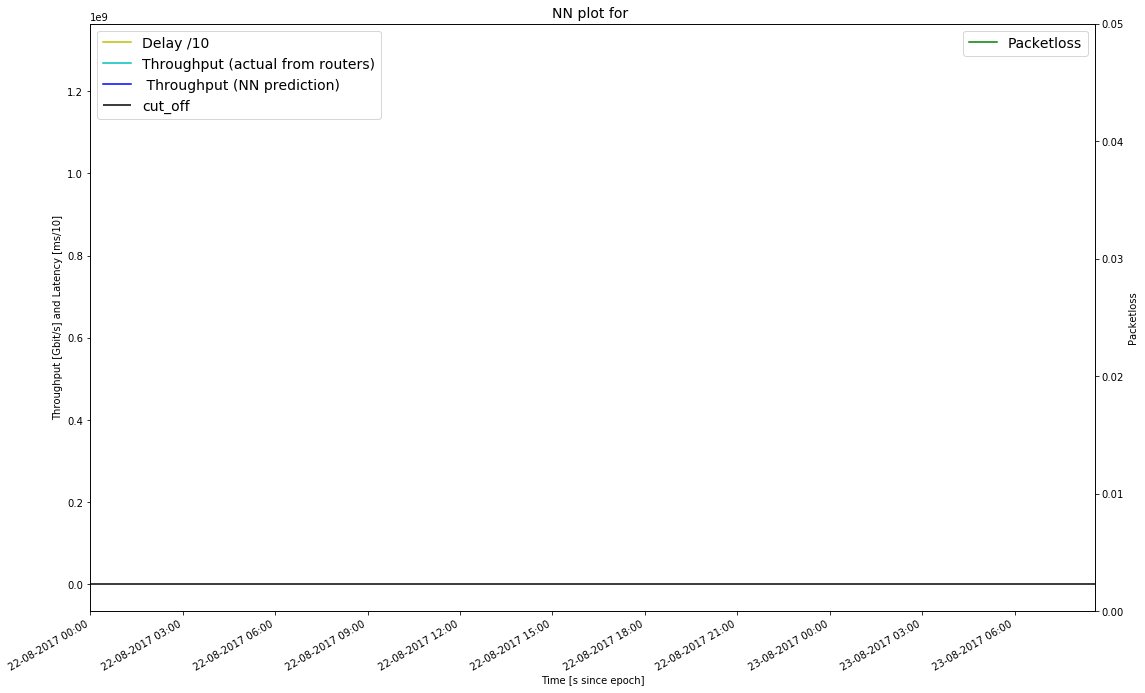

median is: 0.123999


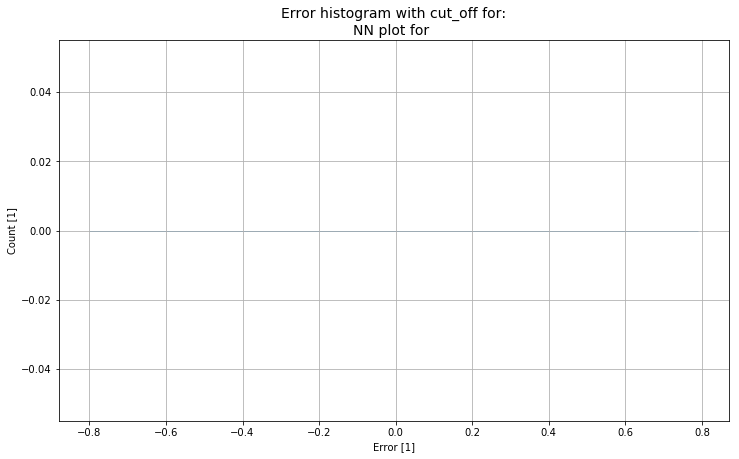

In [226]:
savePath = ''
num_of_last_measurements = 15
throughputMaxGBits = 20
throughputPercentage = 0.7
#savePath = 'plots/router_multi_plots_2016-09-29/'
title_suffix = "\n General NN | "+ str(model.loss) +" for this data set: " + str(score)
timeframe_readable_new = [datetime.datetime.utcfromtimestamp(1503360000).strftime('%d-%m-%Y %H:%M'),
                          datetime.datetime.utcfromtimestamp(1503477381).strftime('%d-%m-%Y %H:%M')]
title_NN_plot = makePlot_forNN(src = 'CERN', dest = dest, timeframe = timeframe_readable_new, data_set_local = data_set_validation, prediction_bw = inverses_normalize_throughput(prediction, throughputMaxGBits), title_suffix=title_suffix, savePath=savePath)

# make error histogram
bins = np.arange(-0.8, 0.8, 0.01)
cut_offset = 0.06
savePath = ''
#savePath = 'plots/router_multi_plots_2016-09-29/'
title = "Error histogram with cut_off for:\n" + title_NN_plot

rs_prediction = np.reshape(prediction, (len(prediction),))
diff = rs_prediction - data_set_normalized_NN_Output.as_matrix()
diff = diff
# cut minimum
minimum = np.median(rs_prediction)
print("median is: "+str(minimum))
validPoints = []
for i in range(len(diff)):
    if rs_prediction[i] >= (minimum+cut_offset):
        validPoints.append(diff[i])
fig, ax1 = plt.subplots()
fig.set_size_inches(12,7)
fig.set_dpi(300)
n, bins, patches = plt.hist(validPoints, bins, normed=False, histtype='step', facecolor='green',
                            alpha=0.75, orientation='vertical')

plt.xlabel("Error [1]")
plt.ylabel('Count [1]')
plt.title(title, fontsize=14)
plt.grid(True)

if savePath != '' :
    fname = title
    plt.savefig(savePath+ fname +'.png', format='PNG', dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

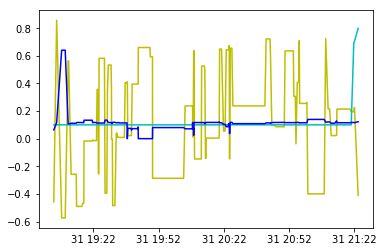

In [82]:
dates_data_set = []
for stamp in data_set_validation['timestamp']:
    dates_data_set.append(datetime.datetime.fromtimestamp(stamp))
plt.plot(dates_data_set, data_set_validation["delay_median"]/10, 'y', label=r'Delay /10')
# get throughput
plt.plot(dates_data_set, (data_set_validation['throughput']), 'c', label=r'Throughput (actual from routers)')
plt.plot(dates_data_set, prediction, 'b', label=r' Throughput (NN prediction)')
plt.show()

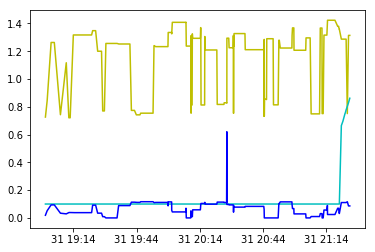

In [86]:
dates_data_set = []
for stamp in data_set_validation['timestamp']:
    dates_data_set.append(datetime.datetime.fromtimestamp(stamp))
plt.plot(dates_data_set, data_set_validation["delay_median"]/10, 'y', label=r'Delay /10')
# get throughput
plt.plot(dates_data_set, (data_set_validation['throughput']), 'c', label=r'Throughput (actual from routers)')
plt.plot(dates_data_set, prediction, 'b', label=r' Throughput (NN prediction)')
plt.show()

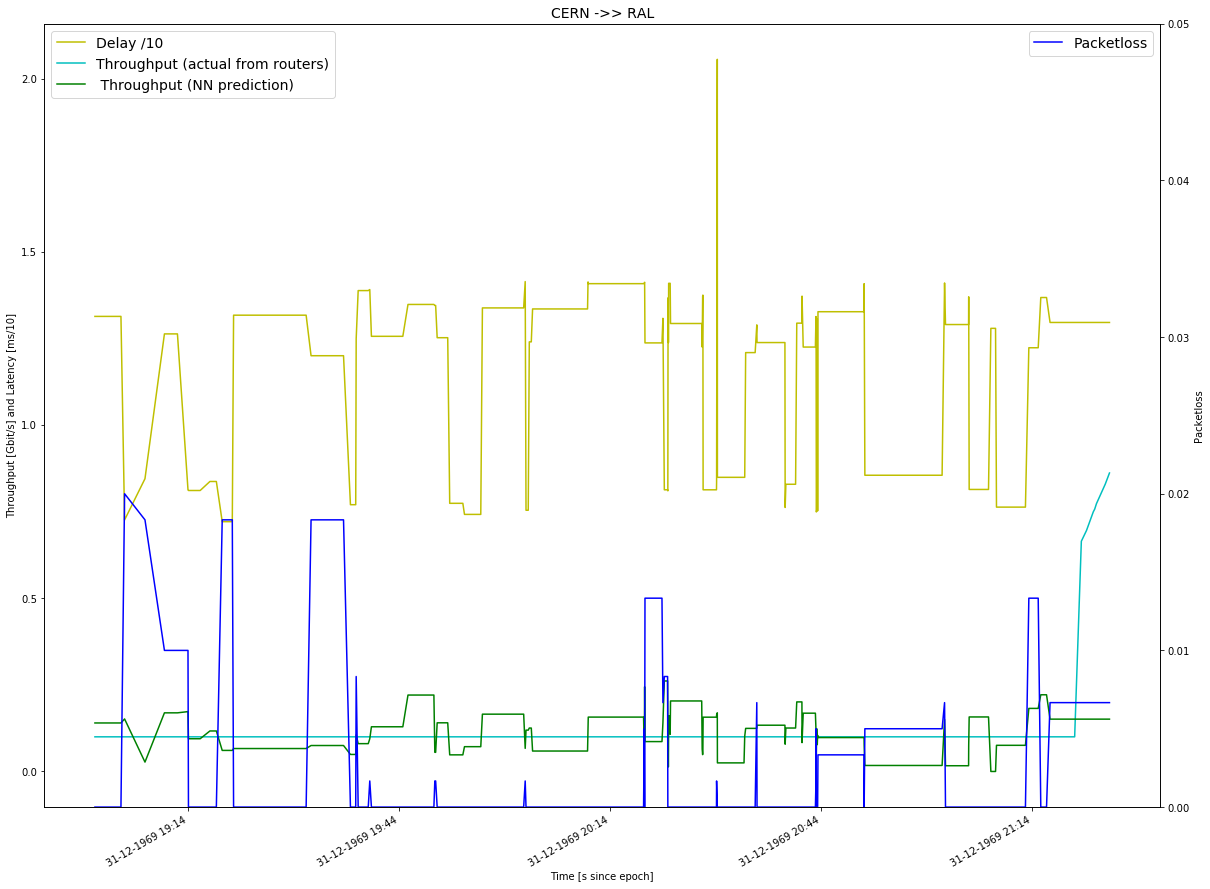

In [148]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20,16)
fig.set_dpi(1000)
# plt.title(title,fontsize=14)
#
# make first axis
# ax1.hlines(inverses_normalize_throughput((minimum+cut_offset), throughputMaxGBits)/1e9, [0], [999999999999999999], label="cut_off")
plt.title("CERN ->> RAL",fontsize=14)
dates_data_set = []
for stamp in data_set_validation['timestamp']:
    dates_data_set.append(datetime.datetime.fromtimestamp(stamp))
ax1.plot(dates_data_set, data_set_validation["delay_median"]/10, 'y', label=r'Delay /10')
# get throughput
ax1.plot(dates_data_set, data_set_validation['throughput'], 'c', label=r'Throughput (actual from routers)')
ax1.plot(dates_data_set, prediction, 'g', label=r' Throughput (NN prediction)')

# make second axis
ax2 = ax1.twinx()
ax2.plot(dates_data_set, data_set_validation["packet_loss"], 'b', label=r'Packetloss')

# limits
#ax1.set_ylim([0, 20])
ax2.set_ylim([0, 0.05])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
plt.gcf().autofmt_xdate()
# legends and lables
ax1.set_ylabel("Throughput [Gbit/s] and Latency [ms/10]")
ax1.set_xlabel("Time [s since epoch]")
ax1.legend(loc='upper left',fontsize=14)
ax2.set_ylabel("Packetloss")
ax2.legend(loc='upper right',fontsize=14)
# saving?
plt.show()

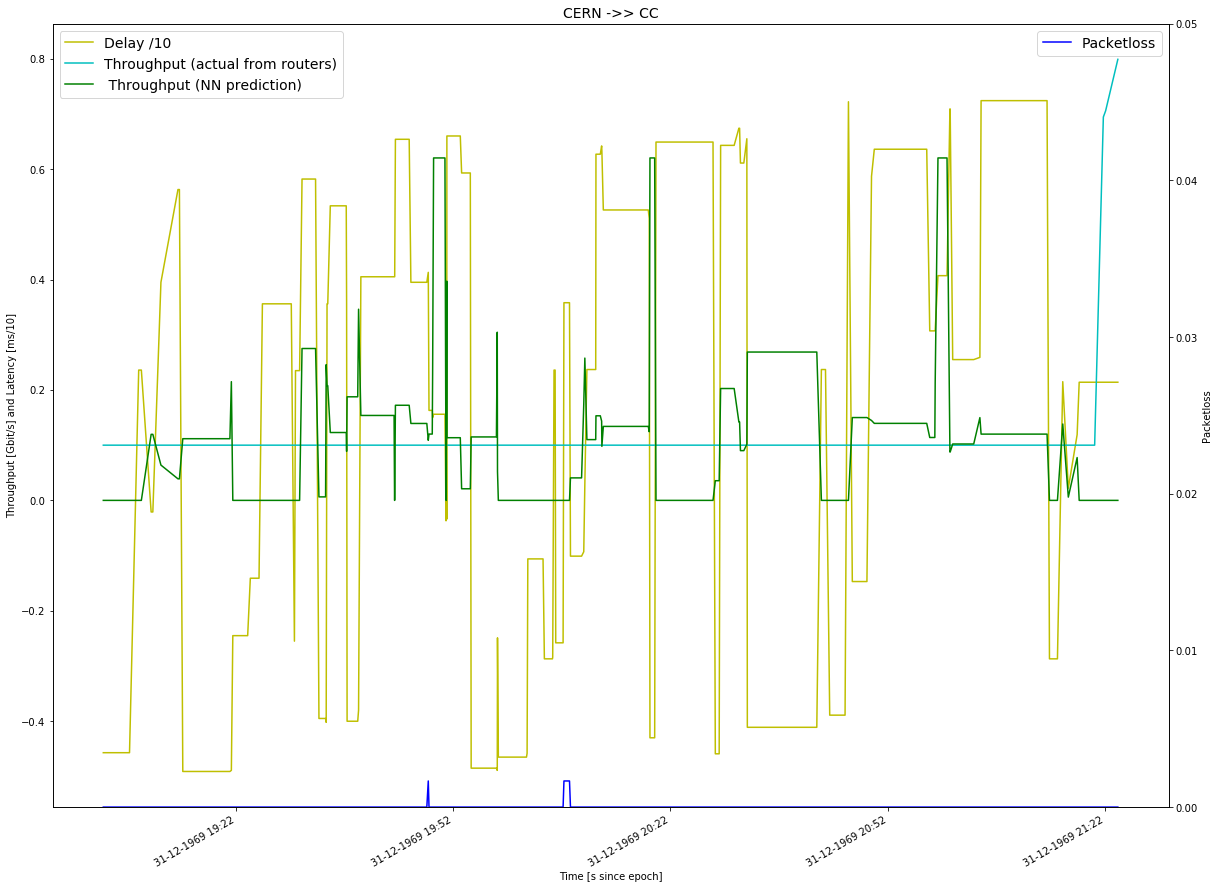

In [167]:
fig, ax1 = plt.subplots()
fig.set_size_inches(20,16)
fig.set_dpi(1000)
# plt.title(title,fontsize=14)
#
# make first axis
# ax1.hlines(inverses_normalize_throughput((minimum+cut_offset), throughputMaxGBits)/1e9, [0], [999999999999999999], label="cut_off")
plt.title("CERN ->> CC",fontsize=14)
dates_data_set = []
for stamp in data_set_validation['timestamp']:
    dates_data_set.append(datetime.datetime.fromtimestamp(stamp))
ax1.plot(dates_data_set, data_set_validation["delay_median"]/10, 'y', label=r'Delay /10')
# get throughput
ax1.plot(dates_data_set, data_set_validation['throughput'], 'c', label=r'Throughput (actual from routers)')
ax1.plot(dates_data_set, prediction, 'g', label=r' Throughput (NN prediction)')

# make second axis
ax2 = ax1.twinx()
ax2.plot(dates_data_set, data_set_validation["packet_loss"], 'b', label=r'Packetloss')

# limits
#ax1.set_ylim([0, 20])
ax2.set_ylim([0, 0.05])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
plt.gcf().autofmt_xdate()
# legends and lables
ax1.set_ylabel("Throughput [Gbit/s] and Latency [ms/10]")
ax1.set_xlabel("Time [s since epoch]")
ax1.legend(loc='upper left',fontsize=14)
ax2.set_ylabel("Packetloss")
ax2.legend(loc='upper right',fontsize=14)
# saving?
plt.show()